In [2]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from galsim import ImageF, InterpolatedImage, Image
import galsim

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.utils import util
from mejiro.instruments.hwo import HWO
from mejiro.synthetic_image import SyntheticImage
from mejiro.lenses.test import SampleStrongLens
from mejiro.exposure import Exposure

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


Computing on pixel grid of size 125x125 (5.0"x5.0") with pixel scale 0.04 arcsec/pixel (natively 0.04 arcsec/pixel oversampled by factor 1)
Initialized SyntheticImage for StrongLens SAMPLE by HWO in J band


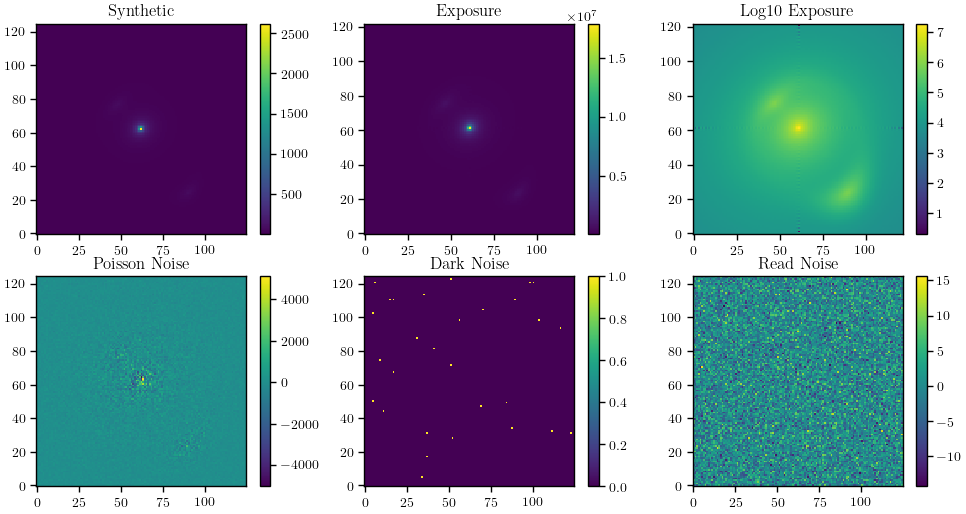

In [3]:
lens = SampleStrongLens()
hwo = HWO()
band = 'J'
scene_size = 5  # arcsec
oversample = 1
exposure_time = 10000
rng = galsim.UniformDeviate(42)

synth_no_subhalo = SyntheticImage(lens, hwo, band, arcsec=scene_size, oversample=oversample)
exposure_no_subhalo = Exposure(synth_no_subhalo, exposure_time=exposure_time, rng=rng, detector_effects=True, sky_background=True, return_noise=True)

_, ax = plt.subplots(2, 3, figsize=(12, 6))
ax00 = ax[0,0].imshow(synth_no_subhalo.image)
ax01 = ax[0,1].imshow(exposure_no_subhalo.exposure)
ax02 = ax[0,2].imshow(np.log10(exposure_no_subhalo.exposure))
ax10 = ax[1,0].imshow(exposure_no_subhalo.poisson_noise.array)
ax11 = ax[1,1].imshow(exposure_no_subhalo.dark_noise.array)
ax12 = ax[1,2].imshow(exposure_no_subhalo.read_noise.array)
plt.colorbar(ax00, ax=ax[0,0])
plt.colorbar(ax01, ax=ax[0,1])
plt.colorbar(ax02, ax=ax[0,2])
plt.colorbar(ax10, ax=ax[1,0])
plt.colorbar(ax11, ax=ax[1,1])
plt.colorbar(ax12, ax=ax[1,2])
ax[0,0].set_title('Synthetic')
ax[0,1].set_title('Exposure')
ax[0,2].set_title('Log10 Exposure')
ax[1,0].set_title('Poisson Noise')
ax[1,1].set_title('Dark Noise')
ax[1,2].set_title('Read Noise')
plt.show()

In [4]:
def divide_up_grid(axis, sides):
    sub_array_size = axis / sides
    centers = []

    for i in range(sides):
        for j in range(sides):
            center_x = int(round((i + 0.5) * sub_array_size))
            center_y = int(round((j + 0.5) * sub_array_size))
            centers.append((center_x, center_y))
    
    return centers

In [5]:
pprint(divide_up_grid(125, 3))  # Example usage

[(21, 21),
 (21, 62),
 (21, 104),
 (62, 21),
 (62, 62),
 (62, 104),
 (104, 21),
 (104, 62),
 (104, 104)]


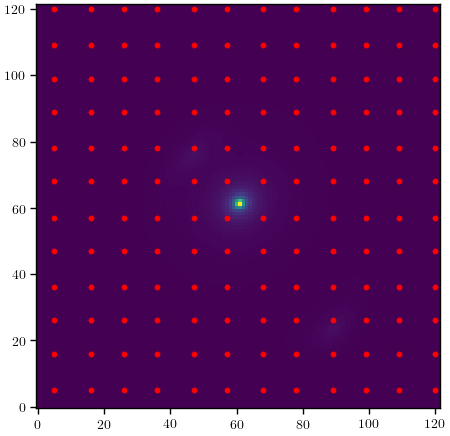

In [6]:
synth_no_subhalo.set_native_coords()

plt.imshow(exposure_no_subhalo.exposure)

for x, y in divide_up_grid(125, 12):
    plt.scatter(x, y, color='red', s=10)

plt.show()

In [7]:
masses = np.logspace(6, 8, 100)
concentration = 6
m200 = 1e8  # TODO temp

# compute subhalo parameters
Rs_angle, alpha_Rs = lens.lens_cosmo.nfw_physical2angle(M=m200, c=concentration)

# build subhalo parameters
subhalo_type = 'TNFW'
kwargs_subhalo = {
    'alpha_Rs': alpha_Rs,
    'Rs': Rs_angle,
    'center_x': center_x,
    'center_y': center_y,
    'r_trunc': 5 * Rs_angle
}

NameError: name 'center_x' is not defined

In [ ]:
lens_with_subhalo = deepcopy(lens)
lens_with_subhalo.add_subhalos(single_halo)
synth = SyntheticImage(lens_with_subhalo, roman, band=band, arcsec=scene_size, oversample=oversample, sca=sca, 
                                    sca_position=sca_position)
exposure = Exposure(synth, exposure_time=exposure_time, rng=rng, sca=sca, 
                                    sca_position=sca_position, poisson_noise=poisson_noise, dark_noise=dark_noise, read_noise=read_noise, reciprocity_failure=False, nonlinearity=False, ipc=False)

synth.set_native_coords()
coords_x, coords_y = synth.coords_native.map_coord2pix(halo_x, halo_y)

plt.imshow(exposure.exposure)
plt.scatter(coords_x, coords_y, color='red')
plt.colorbar()
plt.show()

In [ ]:
residual = exposure.exposure - exposure_no_subhalo.exposure
synth_residual = synth.image - synth_no_subhalo.image
                        
chi_square = stats.chi_square(exposure.exposure, exposure_no_subhalo.exposure)

# vmax = plot_util.get_limit(residual)
# vmax_synth = plot_util.get_limit(synth_residual)

_, ax = plt.subplots(1, 2, figsize=(12, 6))
ax0 = ax[0].imshow(residual, cmap='bwr')  # , vmin=-vmax, vmax=vmax
ax[0].set_title(r'$\chi^2=$ ' + f'{chi_square:.4f}')
ax1 = ax[1].imshow(synth_residual, cmap='bwr')  # , vmin=-vmax_synth, vmax=vmax_synth
plt.colorbar(ax0, ax=ax[0])
plt.colorbar(ax1, ax=ax[1])
plt.show()